# Import Library

In [1]:
# data visualization and utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import graphviz
%matplotlib inline

In [2]:
# classifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import Lasso

In [3]:
# evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score

In [4]:
# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

In [5]:
def regression_report(y_test, y_pred):
    
    space_tab = 3
    
    if len(y_test) != len(y_pred):
        return 'length of true labels and predicted labels are not equal.'
    
    report = []
    
    # labels
    labels = set(y_test)
    for label in labels:
        test = [1 if each==label else 0 for each in y_test]
        pred = [1 if each==label else 0 for each in y_pred]
        report.append([
            label, 
            round(r2_score(test,pred), 3), 
            round(mean_squared_error(test, pred),3), 
            round(explained_variance_score(test,pred),3), 
            y_test.count(label)
        ])
    
    # macro
    macro = [
        'macro avg', 
        round(sum([row[1] for row in report]) / len(labels),3), 
        round(sum([row[2] for row in report]) / len(labels),3), 
        round(sum([row[3] for row in report]) / len(labels),3), 
        sum([row[4] for row in report])
    ]           
    
    # micro    
    diff = [1 if y_test[i]==y_pred[i] else 0 for i in range(len(y_test))]
    same = [1] * len(y_test)
    micro = [
        'micro avg', 
        round(r2_score(diff,same),3), 
        round(mean_squared_error(diff,same), 3),
        round(explained_variance_score(diff,same), 3),
        len(y_test)
    ]
    
    #formatting
    space = ['    ', '    ', '    ', '    ', '    ']    
    header = ['    ', 'r2_score', 'mean_squared_error', 'explained_variance_score', 'support']
    
    # add all the things    
    report.insert(0,space)
    report.insert(0,header)
    report.append(space)
    report.append(micro)
    report.append(macro)        
    
    result = ''
    
    col = []
    for i in range(len(report[0])):
        col.append(max([len(str(row[i])) for row in report])+space_tab)
    
    for row in report:
        for i in range(len(row)):
            result += str(row[i]).rjust(col[i], ' ')
        result += '\n'
    return result   

# Import Dataset

In [6]:
loan_raw = pd.read_csv('kiva_loans.csv')

In [7]:
loan_std = pd.read_csv('kiva_loans_standardized.csv')

In [8]:
loan_cod = pd.read_csv('kiva_loans_dummied.csv')

# Model Selection

## Standardized and One-hot Encoded Dataset

In [9]:
selected_features = list(loan_std.columns)
selected_features.remove('repayment_interval_irregular')
selected_features.remove('repayment_interval_monthly')
selected_features.remove('repayment_interval_weekly')
selected_features.remove('repayment_interval_bullet')

In [10]:
y = loan_raw['repayment_interval']
X = loan_std[selected_features]

In [11]:
X.head()

,loan_amount,activity_Adult Care,activity_Agriculture,activity_Air Conditioning,activity_Animal Sales,activity_Aquaculture,activity_Arts,activity_Auto Repair,activity_Bakery,activity_Balut-Making,...,country_code_WS,country_code_XK,country_code_YE,country_code_ZA,country_code_ZM,country_code_ZW,term_in_months,lender_count,count_male,count_female
0,-0.452503,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.202237,-0.301864,-0.366848,-0.196463
1,-0.223080,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.318531,-0.231589,-0.366848,0.133120
2,-0.577643,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.402867,-0.512690,-0.366848,-0.196463
3,-0.535929,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.318531,-0.442415,-0.366848,-0.196463
4,-0.369076,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.030350,-0.161314,-0.366848,-0.196463


In [12]:
y.head()

0    irregular
1    irregular
2       bullet
3    irregular
4      monthly
Name: repayment_interval, dtype: object

In [16]:
model = Perceptron(tol=100)
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.58      0.70      0.63     70728
   irregular       0.80      0.70      0.75    257158
     monthly       0.77      0.80      0.79    342717
      weekly       0.07      0.28      0.12       602

   micro avg       0.75      0.75      0.75    671205
   macro avg       0.56      0.62      0.57    671205
weighted avg       0.76      0.75      0.76    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.089                0.086                      0.095     70728
     monthly      0.115                0.221                      0.1

In [17]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  0


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  1


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  2


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  3


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  4


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  5


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  6


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  7


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  8


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finish Test Iteration  9


c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      bullet       0.76      0.70      0.73     70728
   irregular       0.85      0.78      0.81    257158
     monthly       0.81      0.87      0.84    342717
      weekly       0.00      0.00      0.00       602

   micro avg       0.82      0.82      0.82    671205
   macro avg       0.60      0.59      0.59    671205
weighted avg       0.82      0.82      0.82    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.412                0.055                      0.413     70728
     monthly      0.306                0.173                      0.313    342717
      weekly     -0.001                0.001                        0.0       602
   irregular      0.418                0.138                      0.422    257158
                                                                         

In [18]:
model = DTC()
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.84      0.85      0.85     70728
   irregular       0.89      0.91      0.90    257158
     monthly       0.92      0.90      0.91    342717
      weekly       0.74      0.71      0.72       602

   micro avg       0.90      0.90      0.90    671205
   macro avg       0.85      0.84      0.85    671205
weighted avg       0.90      0.90      0.90    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.652                0.033                      0.652     70728
     monthly      0.633                0.092                      0.6

In [19]:
model = RandomForestClassifier(n_estimators = 10)
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.85      0.87      0.86     70728
   irregular       0.90      0.92      0.91    257158
     monthly       0.92      0.91      0.91    342717
      weekly       0.76      0.66      0.71       602

   micro avg       0.91      0.91      0.91    671205
   macro avg       0.86      0.84      0.85    671205
weighted avg       0.91      0.91      0.91    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.681                 0.03                      0.681     70728
     monthly      0.653                0.087                      0.6

## LDA

### Make Dataset

In [21]:
lda = LDA()

In [23]:
X_lda = lda.fit_transform(X,y)

c:\program files\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [25]:
X_lda = pd.DataFrame(X_lda)
X_lda.head()

,0,1,2
0,0.086983,1.040320,-0.562090
1,0.494302,0.432548,-0.162151
2,-2.647295,-1.788989,0.173327
3,-0.401801,1.321277,-0.195425
4,-0.559861,1.431758,-0.435636


In [34]:
lda.coef_

array([[-0.32562241, -5.99492117,  3.61883626, ...,  0.00813602,
         1.13439587,  0.33434661],
       [ 0.23618892,  0.3534263 , -0.29351735, ..., -0.24044066,
        -0.20702388,  0.29114146],
       [-0.10914712,  0.97252816, -0.52788556, ...,  0.17736675,
        -0.07761124, -0.28690328],
       [-0.49946169, -0.29825081,  0.73528292, ...,  0.77939338,
        -0.65949194, -0.31626346]])

In [35]:
lda.intercept_

array([ -6.92498434,  -2.44000487,  -0.90461735, -18.28189367])

In [36]:
lda.explained_variance_ratio_

array([0.63453768, 0.35685485, 0.00860747])

## Model Tests

In [33]:
model = Perceptron(tol = 100)
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_lda):
    
    X_train, X_test = X_lda.iloc[train_index], X_lda.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.52      0.78      0.62     70728
   irregular       0.86      0.73      0.79    257158
     monthly       0.81      0.82      0.82    342717
      weekly       0.00      0.00      0.00       602

   micro avg       0.78      0.78      0.78    671205
   macro avg       0.55      0.58      0.56    671205
weighted avg       0.80      0.78      0.79    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet     -0.051                0.099                     -0.021     70728
     monthly      0.252                0.187                      0.2

In [29]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_lda):
    
    X_train, X_test = X_lda.iloc[train_index], X_lda.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9


c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      bullet       0.73      0.63      0.67     70728
   irregular       0.86      0.76      0.81    257158
     monthly       0.78      0.88      0.83    342717
      weekly       0.00      0.00      0.00       602

   micro avg       0.81      0.81      0.81    671205
   macro avg       0.59      0.57      0.58    671205
weighted avg       0.81      0.81      0.80    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.325                0.064                      0.327     70728
     monthly      0.254                0.186                      0.268    342717
      weekly     -0.001                0.001                        0.0       602
   irregular      0.417                0.138                      0.425    257158
                                                                         

In [27]:
model = DTC()
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_lda):
    
    X_train, X_test = X_lda.iloc[train_index], X_lda.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.78      0.79      0.79     70728
   irregular       0.84      0.85      0.85    257158
     monthly       0.86      0.85      0.86    342717
      weekly       0.53      0.48      0.50       602

   micro avg       0.85      0.85      0.85    671205
   macro avg       0.75      0.74      0.75    671205
weighted avg       0.85      0.85      0.85    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.524                0.045                      0.524     70728
     monthly      0.422                0.144                      0.4

In [28]:
model = RandomForestClassifier(n_estimators = 10)
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_lda):
    
    X_train, X_test = X_lda.iloc[train_index], X_lda.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.81      0.83      0.82     70728
   irregular       0.86      0.87      0.87    257158
     monthly       0.88      0.87      0.88    342717
      weekly       0.64      0.45      0.52       602

   micro avg       0.87      0.87      0.87    671205
   macro avg       0.80      0.76      0.77    671205
weighted avg       0.87      0.87      0.87    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.597                0.038                      0.597     70728
     monthly        0.5                0.125                        0

In [26]:
model = KNN(n_neighbors=10)
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_lda):
    
    X_train, X_test = X_lda.iloc[train_index], X_lda.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.81      0.86      0.83     70728
   irregular       0.87      0.89      0.88    257158
     monthly       0.90      0.87      0.89    342717
      weekly       0.58      0.39      0.47       602

   micro avg       0.88      0.88      0.88    671205
   macro avg       0.79      0.75      0.77    671205
weighted avg       0.88      0.88      0.88    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.616                0.036                      0.616     70728
     monthly      0.538                0.115                      0.5

In [ ]:
model = SVC(gamma='auto')
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_lda):
    
#     print('Start Test Iteration ',i)
    X_train, X_test = X_lda.iloc[train_index[:10000]], X_lda.iloc[test_index[:1000]]
    y_train, y_test = y.iloc[train_index[:10000]], y.iloc[test_index[:1000]]

#     print('Start Fitting Iteration ',i)
    model.fit(X_train,y_train)    
#     print('Start Prediction Iteration ',i)
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

## Summary

After all these testing, random forest without LDA preprocessing is selected.  

It has the highest precision (macro) and precision (weekly).  Weekly is important as it has the lowest score among all classes for any indicators.  

# Advanced Training

## Tune Parameters

In [13]:
score = []
j = 1
min_impurity_decrease_ = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 0]
for j in range(len(min_impurity_decrease_)):
            
    dtree = RandomForestClassifier(min_impurity_decrease = min_impurity_decrease_[j], n_estimators = 10)

    ALL_TRUE_LABEL = []
    ALL_PRED_LABEL = []
    kf = KFold(n_splits=10)
    i = 0

    for train_index, test_index in kf.split(X):    

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dtree.fit(X_train,y_train)
        ALL_PRED_LABEL.extend(dtree.predict(X_test))
        ALL_TRUE_LABEL.extend(y_test)

        # Screen Output for tracking the progress, sometimes I wait too long......
        print('Finish Test Iteration ',i)
        i += 1
    score.append(precision_score(ALL_TRUE_LABEL, ALL_PRED_LABEL, average = 'macro'))
    print('Finish Subset Iteration ',j)

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9


c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Finish Subset Iteration  0
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9


c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Finish Subset Iteration  1
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9


c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Finish Subset Iteration  2
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9


c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Finish Subset Iteration  3
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9


c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Finish Subset Iteration  4
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
Finish Subset Iteration  5
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
Finish Subset Iteration  6
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
Finish Subset Iteration  7
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Itera

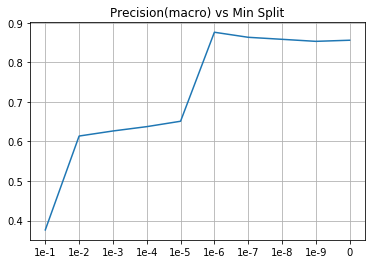

In [14]:
min_split = ['1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7', '1e-8', '1e-9', '0']

plt.plot(min_split, score)
# plt.xlabel('Precision(macro)')
# plt.ylabel('Minimum Split')
plt.grid()
plt.title('Precision(macro) vs Min Split')
plt.show()

1e-6 is the best choice

In [15]:
score = []
j = 1
for j in range(1,11):
            
    dtree = RandomForestClassifier(min_impurity_decrease = 1e-6, n_estimators = 10*j)

    ALL_TRUE_LABEL = []
    ALL_PRED_LABEL = []
    kf = KFold(n_splits=10)
    i = 0

    for train_index, test_index in kf.split(X):    

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dtree.fit(X_train,y_train)
        ALL_PRED_LABEL.extend(dtree.predict(X_test))
        ALL_TRUE_LABEL.extend(y_test)

        # Screen Output for tracking the progress, sometimes I wait too long......
        print('Finish Test Iteration ',i)
        i += 1
    score.append(precision_score(ALL_TRUE_LABEL, ALL_PRED_LABEL, average = 'macro'))
    print('Finish Subset Iteration ',j)

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
Finish Subset Iteration  1
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
Finish Subset Iteration  2
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
Finish Subset Iteration  3
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iterati

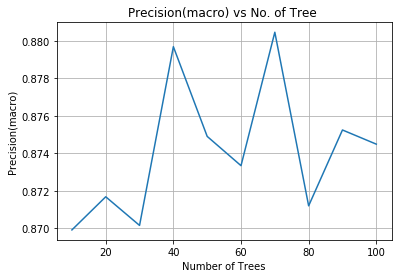

In [21]:
no_of_trees = [i*10 for i in range(1,11)]

plt.plot(no_of_trees, score)
plt.xlabel('Number of Trees')
plt.ylabel('Precision(macro)')
plt.grid()
plt.title('Precision(macro) vs No. of Tree ')
plt.show()

Seems 70 is the best choice.  

In [25]:
score = []
j = 1
for j in range(1,11):
            
    dtree = RandomForestClassifier(min_impurity_decrease = 1e-6, n_estimators = 70, max_depth = 10000 * j)

    ALL_TRUE_LABEL = []
    ALL_PRED_LABEL = []
    kf = KFold(n_splits=10)
    i = 0
    

    for train_index, test_index in kf.split(X):    

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]        
        dtree.fit(X_train,y_train)
        ALL_PRED_LABEL.extend(dtree.predict(X_test))
        ALL_TRUE_LABEL.extend(y_test)

        # Screen Output for tracking the progress, sometimes I wait too long......
        print('Finish Test Iteration ',i)
        i += 1    
    score.append(precision_score(ALL_TRUE_LABEL, ALL_PRED_LABEL, average = 'macro'))
    print('Finish Subset Iteration ',j)

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
Finish Subset Iteration  1
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
Finish Subset Iteration  2
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
Finish Subset Iteration  3
Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iterati

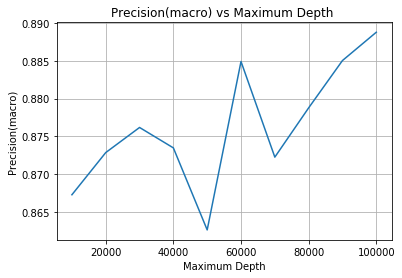

In [27]:
max_depth = [i*10000 for i in range(1,11)]

plt.plot(max_depth, score)
plt.xlabel('Maximum Depth')
plt.ylabel('Precision(macro)')
plt.grid()
plt.title('Precision(macro) vs Maximum Depth ')
plt.show()

I guess unlimited depth is better.  

In [14]:
# Final Testing

In [15]:
model = RandomForestClassifier(min_impurity_decrease = 1e-6, n_estimators = 70, max_depth = 100000)
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.87      0.85      0.86     70728
   irregular       0.91      0.91      0.91    257158
     monthly       0.91      0.92      0.91    342717
      weekly       0.77      0.15      0.26       602

   micro avg       0.91      0.91      0.91    671205
   macro avg       0.87      0.71      0.73    671205
weighted avg       0.91      0.91      0.91    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      weekly      0.107                0.001                      0.108       602
   irregular      0.707                0.069                      0.7

## Filtering

### Make Dataset

In [54]:
selected_features = list(loan_std.columns)
selected_features.remove('repayment_interval_irregular')
selected_features.remove('repayment_interval_monthly')
selected_features.remove('repayment_interval_bullet')

X_filter = loan_std[selected_features]

In [55]:
X_filter.head()

,loan_amount,activity_Adult Care,activity_Agriculture,activity_Air Conditioning,activity_Animal Sales,activity_Aquaculture,activity_Arts,activity_Auto Repair,activity_Bakery,activity_Balut-Making,...,country_code_XK,country_code_YE,country_code_ZA,country_code_ZM,country_code_ZW,term_in_months,lender_count,repayment_interval_weekly,count_male,count_female
0,-0.452503,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-0.202237,-0.301864,0,-0.366848,-0.196463
1,-0.223080,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-0.318531,-0.231589,0,-0.366848,0.133120
2,-0.577643,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.402867,-0.512690,0,-0.366848,-0.196463
3,-0.535929,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-0.318531,-0.442415,0,-0.366848,-0.196463
4,-0.369076,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.030350,-0.161314,0,-0.366848,-0.196463


### Model

In [57]:
# from experiment, 7 seconds for each iteration

dtree1 = DTC()
dtree2 = DTC()

ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_filter):
    
    X_train, X_test = X_filter.iloc[train_index], X_filter.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    selected_columns = list(X_filter.columns)
    selected_columns.remove('repayment_interval_weekly')
    
    # make a dataset only contains `weekly` and `non-weekly` label
    dataset_weekly_train, dataset_weekly_test = X_train[selected_columns], X_test[selected_columns]
    label_weekly_train, label_weekly_test = X_train['repayment_interval_weekly'], X_test['repayment_interval_weekly']
    
    # make a dataset without `weekly` data and label
    dataset_no_weekly_train, dataset_no_weekly_test = X_train.loc[X_train['repayment_interval_weekly'] < 1], X_test.loc[X_test['repayment_interval_weekly'] < 1]
    dataset_no_weekly_train, dataset_no_weekly_test = dataset_no_weekly_train[selected_columns], dataset_no_weekly_test[selected_columns]
    label_no_weekly_train, label_no_weekly_test = y_train.loc[y_train != 'weekly'], y_test.loc[y_test != 'weekly']
        
    # train a dtree for recognizing `weekly` or not
    dtree1.fit(dataset_weekly_train,label_weekly_train)
        
    # train a dtree for recognizing `irregular`,`monthly` and `bullet`        
    dtree2.fit(dataset_no_weekly_train,label_no_weekly_train)
    
    # start prediction
    y_pred_1 = dtree1.predict(dataset_weekly_test)  
    y_pred_2 = dtree2.predict(dataset_weekly_test)
    
#     print(sum(y_pred_1))
    
    # Merge Prediction Result
    y_pred = []
    for j in range(len(test_index)):
        if y_pred_1[j]:
            y_pred.append('weekly')
        else:
            y_pred.append(y_pred_2[j])

    ALL_PRED_LABEL.extend(y_pred)
    ALL_TRUE_LABEL.extend(y_test)
    
    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break
    
print(classification_report(ALL_TRUE_LABEL,ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL,ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL,ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.84      0.85      0.85     70728
   irregular       0.89      0.91      0.90    257158
     monthly       0.92      0.90      0.91    342717
      weekly       0.71      0.71      0.71       602

   micro avg       0.90      0.90      0.90    671205
   macro avg       0.84      0.84      0.84    671205
weighted avg       0.90      0.90      0.90    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.653                0.033                      0.653     70728
     monthly      0.632                0.092                      0.6

# Conclusion

In [43]:
model = DTC(min_impurity_decrease=1e-5, max_depth = 61000)
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)    
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1
#     break

print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

Finish Test Iteration  0
Finish Test Iteration  1
Finish Test Iteration  2
Finish Test Iteration  3
Finish Test Iteration  4
Finish Test Iteration  5
Finish Test Iteration  6
Finish Test Iteration  7
Finish Test Iteration  8
Finish Test Iteration  9
              precision    recall  f1-score   support

      bullet       0.85      0.88      0.86     70728
   irregular       0.92      0.92      0.92    257158
     monthly       0.93      0.92      0.92    342717
      weekly       0.74      0.84      0.79       602

   micro avg       0.92      0.92      0.92    671205
   macro avg       0.86      0.89      0.87    671205
weighted avg       0.92      0.92      0.92    671205

               r2_score   mean_squared_error   explained_variance_score   support
                                                                                 
      bullet      0.693                0.029                      0.693     70728
     monthly      0.688                0.078                      0.6

In [13]:
print(ALL_TRUE_LABEL)

['irregular', 'irregular', 'bullet', 'irregular', 'monthly', 'irregular', 'bullet', 'monthly', 'monthly', 'irregular', 'irregular', 'monthly', 'monthly', 'irregular', 'bullet', 'irregular', 'monthly', 'irregular', 'bullet', 'monthly', 'irregular', 'irregular', 'irregular', 'monthly', 'irregular', 'bullet', 'bullet', 'irregular', 'bullet', 'bullet', 'irregular', 'monthly', 'monthly', 'bullet', 'monthly', 'irregular', 'irregular', 'monthly', 'irregular', 'monthly', 'irregular', 'monthly', 'irregular', 'irregular', 'monthly', 'bullet', 'irregular', 'bullet', 'monthly', 'monthly', 'monthly', 'irregular', 'irregular', 'monthly', 'monthly', 'irregular', 'irregular', 'irregular', 'irregular', 'irregular', 'monthly', 'irregular', 'bullet', 'irregular', 'monthly', 'irregular', 'irregular', 'irregular', 'irregular', 'monthly', 'monthly', 'irregular', 'irregular', 'irregular', 'irregular', 'irregular', 'irregular', 'monthly', 'irregular', 'irregular', 'monthly', 'monthly', 'monthly', 'monthly', '

In [14]:
print(ALL_PRED_LABEL)

['monthly', 'irregular', 'monthly', 'monthly', 'monthly', 'irregular', 'bullet', 'monthly', 'monthly', 'monthly', 'irregular', 'monthly', 'monthly', 'monthly', 'bullet', 'irregular', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'bullet', 'monthly', 'irregular', 'bullet', 'bullet', 'monthly', 'monthly', 'monthly', 'bullet', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'irregular', 'bullet', 'monthly', 'bullet', 'monthly', 'monthly', 'monthly', 'irregular', 'irregular', 'monthly', 'monthly', 'irregular', 'irregular', 'irregular', 'monthly', 'irregular', 'monthly', 'irregular', 'monthly', 'monthly', 'monthly', 'irregular', 'irregular', 'irregular', 'irregular', 'monthly', 'monthly', 'irregular', 'irregular', 'irregular', 'irregular', 'irregular', 'irregular', 'irregular', 'irregular', 'irregular', 'monthly', 'monthly', 'monthly', 'irregular', 'monthly', 'bullet', 'monthly

In [62]:
print(classification_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL))
print(confusion_matrix(ALL_TRUE_LABEL, ALL_PRED_LABEL))

c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      bullet       0.76      0.40      0.52      5416
   irregular       0.80      0.84      0.82     18960
     monthly       0.78      0.84      0.81     25556
      weekly       0.00      0.00      0.00        68

   micro avg       0.79      0.79      0.79     50000
   macro avg       0.59      0.52      0.54     50000
weighted avg       0.79      0.79      0.78     50000

                           r2_score     mean_squared_error  explained_variance_score  support
                                                                                             
     bullet     0.18208266221317637                  0.079       0.20926586125179913     5416
  irregular     0.40545614206794556                0.13996       0.40671870921962683    18960
     weekly  -0.0013618521188816235                0.00136                       0.0       68
    monthly      0.1916001512069495                  0.202        0.1966039445712141    25556
 

In [6]:
loan = pd.read_csv('kiva_loans.csv')

In [7]:
loan.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date'],
      dtype='object')

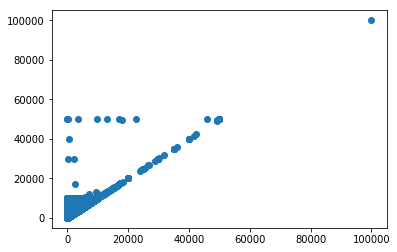

In [8]:
plt.scatter(loan['funded_amount'], loan['loan_amount'])
plt.show()

In [9]:
loan_std = pd.read_csv('kiva_loans_standardized.csv')

In [ ]:
loan_std.columns

Index(['loan_amount', 'activity_Adult Care', 'activity_Agriculture',
       'activity_Air Conditioning', 'activity_Animal Sales',
       'activity_Aquaculture', 'activity_Arts', 'activity_Auto Repair',
       'activity_Bakery', 'activity_Balut-Making',
       ...
       'country_code_ZM', 'country_code_ZW', 'term_in_months', 'lender_count',
       'repayment_interval_bullet', 'repayment_interval_irregular',
       'repayment_interval_monthly', 'repayment_interval_weekly', 'count_male',
       'count_female'],
      dtype='object', length=274)

In [ ]:
X = loan_std
y = loan['funded_amount']

In [ ]:
X.head()

,loan_amount,activity_Adult Care,activity_Agriculture,activity_Air Conditioning,activity_Animal Sales,activity_Aquaculture,activity_Arts,activity_Auto Repair,activity_Bakery,activity_Balut-Making,...,country_code_ZM,country_code_ZW,term_in_months,lender_count,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly,count_male,count_female
0,-0.452503,0,0,0,0,0,0,0,0,0,...,0,0,-0.202237,-0.301864,0,1,0,0,-0.366848,-0.196463
1,-0.223080,0,0,0,0,0,0,0,0,0,...,0,0,-0.318531,-0.231589,0,1,0,0,-0.366848,0.133120
2,-0.577643,0,0,0,0,0,0,0,0,0,...,0,0,3.402867,-0.512690,1,0,0,0,-0.366848,-0.196463
3,-0.535929,0,0,0,0,0,0,0,0,0,...,0,0,-0.318531,-0.442415,0,1,0,0,-0.366848,-0.196463
4,-0.369076,0,0,0,0,0,0,0,0,0,...,0,0,0.030350,-0.161314,0,0,1,0,-0.366848,-0.196463


In [ ]:
X_lda = LDA().fit_transform(X,y)

c:\program files\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [ ]:
X_lda = pd.DataFrame(X_lda)

In [ ]:
y = pd.DataFrame(y)

In [ ]:
model = LogisticRegression()
ALL_TRUE_LABEL = []
ALL_PRED_LABEL = []
kf = KFold(n_splits=10)
i = 0
model = LogisticRegression()
for train_index, test_index in kf.split(X_lda):

    print('hi')
    X_train, X_test = X_lda.iloc[train_index], X_lda.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train,y_train)
    print('hi2')
    
    ALL_PRED_LABEL.extend(model.predict(X_test))
    ALL_TRUE_LABEL.extend(y_test)

    # Screen Output for tracking the progress, sometimes I wait too long......
    print('Finish Test Iteration ',i)
    i += 1   
    break

regression_report(ALL_TRUE_LABEL, ALL_PRED_LABEL)

hi


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
